# File Download

In [66]:
import pandas as pd
import numpy as np

import datetime

In [67]:
today = pd.to_datetime(datetime.date.today())

year = today.year

ytd = pd.to_datetime(f'01-01-{year}')

t_minus_30 = today - datetime.timedelta(30)

t_minus_90 = today - datetime.timedelta(90)

In [68]:
DATE = '033022'

tax_lot_df = pd.read_csv('/Users/DanCassin/Development/python/etrade_account_dashboard/data/TTM_tax_lots_{DATE}.csv',
            usecols=[
                'Symbol', 'Quantity', 'Opening Date', 'Cost/Share $', 'Total Cost $',
                'Closing Date',	'Price/Share $', 'Proceeds $', 'Gain $'],
            skiprows=13,
            delimiter=',',
            skipfooter=2,
            engine='python'
)

In [69]:
tax_lot_df

Symbol   Quantity Opening Date Cost/Share $  Total Cost $ Closing Date  \
0        AAPL   35.00000           --           --       4684.72           --   
1        Sell   20.00000   06/17/2021       130.09       2601.75   07/16/2021   
2        Sell   15.00000   07/03/2021       138.86       2082.98   07/16/2021   
3         ACB  500.00000           --           --       4899.92           --   
4        Sell   80.00000   10/20/2020         4.36        349.20   03/11/2021   
..        ...        ...          ...          ...           ...          ...   
275      Sell    0.13158   09/25/2020        42.03          5.53   03/30/2021   
276      Sell    0.08087   12/25/2020        48.84          3.95   03/30/2021   
277       YOU   70.00000           --           --       3480.85           --   
278      Sell   20.00000   08/23/2021        49.42        988.35   08/30/2021   
279      Sell   50.00000   08/24/2021        49.85       2492.50   08/30/2021   

    Price/Share $   Proceeds $  Gain $  
0              --  5119.857505  435.13  
1          146.28  2925.632860  323.88  
2          146.28  2194.224645  111.25  
3              --  4563.898280 -336.02  
4           10.35   828.068000  478.87  
..            ...          ...     ...  
275         51.51     6.777808    1.25  
276         51.51     4.165689    0.22  
277            --  3272.471720 -208.38  
278         46.75   934.991920  -53.36  
279         46.75  2337.479800 -155.02  

[280 rows x 9 columns]

In [70]:
tax_lot_df.rename(columns = lambda x: x.lower().replace('$', '').strip().replace(' ','_'), inplace=True)
#tax_lot_df.drop(['deferred_loss', 'term','lot_selection', 'unnamed:_12'], axis=1, inplace=True)

In [71]:
tax_lot_df = tax_lot_df.replace('--', np.nan)
tax_lot_df['symbol']= tax_lot_df['symbol'].str.strip()
tax_lot_df['symbol'].replace('Sell', np.nan, inplace=True)
tax_lot_df['symbol'] = tax_lot_df['symbol'].ffill()

In [72]:
tax_lot_df.dropna(subset=['opening_date'], inplace=True)

In [73]:
tax_lot_df['opening_date'] = tax_lot_df['opening_date'].astype('Datetime64')
tax_lot_df['closing_date'] = tax_lot_df['closing_date'].astype('Datetime64')

In [74]:
tax_lot_df['pct_gain/loss'] = round((tax_lot_df['gain'] / tax_lot_df['total_cost']) * 100, 2)

In [75]:
tax_lot_df['category'] = pd.cut(tax_lot_df.gain, bins=[-5000, .0001, 5000],
    labels=['loss','gain'])

In [76]:
tax_lot_df.head()

symbol  quantity opening_date cost/share  total_cost closing_date  \
1   AAPL      20.0   2021-06-17     130.09     2601.75   2021-07-16   
2   AAPL      15.0   2021-07-03     138.86     2082.98   2021-07-16   
4    ACB      80.0   2020-10-20       4.36      349.20   2021-03-11   
5    ACB      95.0   2021-03-22       9.85      935.49   2021-04-30   
6    ACB     100.0   2021-03-04       9.83      982.78   2021-04-30   

  price/share     proceeds    gain  pct_gain/loss category  
1      146.28  2925.632860  323.88          12.45     gain  
2      146.28  2194.224645  111.25           5.34     gain  
4       10.35   828.068000  478.87         137.13     gain  
5        8.89   845.009230  -90.48          -9.67     loss  
6        8.89   889.483400  -93.30          -9.49     loss

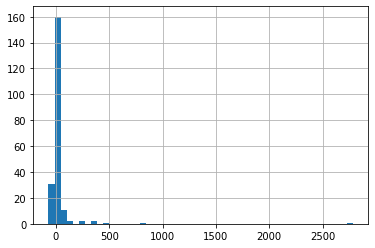

In [77]:
tax_lot_df['pct_gain/loss'].hist(bins=50);

In [78]:
tax_lot_df['pct_gain/loss'].mean()

24.901848341232228

In [79]:
tax_lot_df['pct_gain/loss'].median()

-1.85

In [80]:
tax_lot_df['days_held'] = (tax_lot_df['closing_date'] - tax_lot_df['opening_date']).dt.days

<AxesSubplot:>

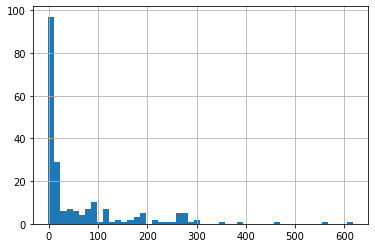

In [81]:
tax_lot_df['days_held'].hist(bins=50)

<AxesSubplot:xlabel='days_held', ylabel='pct_gain/loss'>

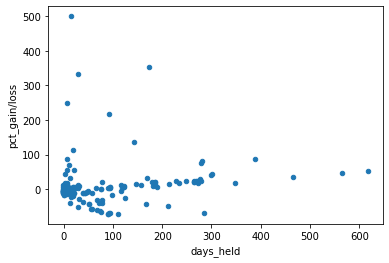

In [82]:
sub_df = tax_lot_df[['pct_gain/loss','days_held']]

sub_df = sub_df[sub_df['pct_gain/loss'] <=500]

sub_df.plot(kind='scatter', x='days_held', y='pct_gain/loss')

In [83]:
print(tax_lot_df['days_held'].mean())
print(tax_lot_df['days_held'].median())

65.13744075829383
14.0


In [84]:
tax_lot_df['days_held']

1       29
2       13
4      142
5       39
6       57
      ... 
274      4
275    186
276     95
278      7
279      6
Name: days_held, Length: 211, dtype: int64

In [85]:
last_90_days = tax_lot_df[tax_lot_df['opening_date'] > pd.to_datetime(t_minus_90)]

<AxesSubplot:>

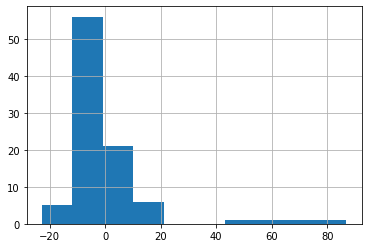

In [86]:
last_90_days['pct_gain/loss'].hist()

<AxesSubplot:>

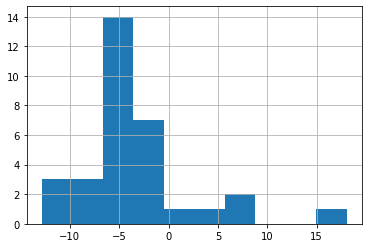

In [87]:
last_30_days = tax_lot_df[tax_lot_df['opening_date'] > pd.to_datetime(t_minus_30)]

last_30_days['pct_gain/loss'].hist()

In [88]:
last_30_losses = last_30_days[last_30_days['pct_gain/loss'] < 0]

round(last_30_losses['gain'].sum(),2)

-1666.67

In [89]:
last_30_gains = last_30_days[last_30_days['pct_gain/loss'] > 0]

last_30_gains['gain'].sum()

255.95999999999998

In [90]:
total_trades_90_days = int(last_90_days.shape[0])

pct_gain_trades_90 = (last_90_days[last_90_days['gain'] > 0].shape[0] / total_trades_90_days) * 100

total_trades_30_days = int(last_30_days.shape[0])

pct_gain_trades_30 = (last_30_days[last_30_days['gain'] > 0].shape[0] / total_trades_30_days) * 100

print(f'Profitable Trades Last 30 Days:\n{round(pct_gain_trades_30, 2)}%')

print(f'Profitable Trades Last 90 Days:\n{round(pct_gain_trades_90, 2)}%')

Profitable Trades Last 30 Days:
15.62%
Profitable Trades Last 90 Days:
30.43%


In [91]:
winning_trades = tax_lot_df[tax_lot_df['gain']> 0]
losing_trades = tax_lot_df[tax_lot_df['gain'] < 0]

total_winning_trades = winning_trades.shape[0]
total_losing_trades = losing_trades.shape[0]

avg_gain = round(winning_trades['gain'].mean(), 2)
avg_loss = abs(round(losing_trades['gain'].mean(), 2))

risk_reward = round((total_winning_trades * avg_gain) / (total_losing_trades * avg_loss), 2)

print(f'Reward/Risk {risk_reward}')

Reward/Risk 1.35


# A Few Intersting Visualizations   

In [92]:
tax_lot_df.head()

symbol  quantity opening_date cost/share  total_cost closing_date  \
1   AAPL      20.0   2021-06-17     130.09     2601.75   2021-07-16   
2   AAPL      15.0   2021-07-03     138.86     2082.98   2021-07-16   
4    ACB      80.0   2020-10-20       4.36      349.20   2021-03-11   
5    ACB      95.0   2021-03-22       9.85      935.49   2021-04-30   
6    ACB     100.0   2021-03-04       9.83      982.78   2021-04-30   

  price/share     proceeds    gain  pct_gain/loss category  days_held  
1      146.28  2925.632860  323.88          12.45     gain         29  
2      146.28  2194.224645  111.25           5.34     gain         13  
4       10.35   828.068000  478.87         137.13     gain        142  
5        8.89   845.009230  -90.48          -9.67     loss         39  
6        8.89   889.483400  -93.30          -9.49     loss         57

In [93]:
import plotly.express as px

less_than_100_pct = tax_lot_df[tax_lot_df['pct_gain/loss'] < 100]

fig = px.density_contour(less_than_100_pct, x="proceeds", y="pct_gain/loss")
fig.show()

In [94]:
less_than_100_pct[less_than_100_pct.category.isnull()]

Empty DataFrame
Columns: [symbol, quantity, opening_date, cost/share, total_cost, closing_date, price/share, proceeds, gain, pct_gain/loss, category, days_held]
Index: []

In [99]:
fig = px.histogram(
        less_than_100_pct, x="pct_gain/loss",
        marginal='box', color='category',
        hover_data=less_than_100_pct.columns,
        nbins=200)

fig.show()

# Additions

- Comparison of last 30 days to last 90, YTD, TTM
- Cumulative count of winning trades losing trades over time
- x axis values - show max values of the data

In [97]:
less_than_100_pct[(less_than_100_pct['pct_gain/loss']<1) & (less_than_100_pct['category'] == 'gain')]

symbol  quantity opening_date cost/share  total_cost closing_date  \
83    CCRN     228.0   2021-06-11      17.51     3992.28   2021-06-22   
95     DIA      20.0   2021-06-05     347.55     6950.98   2021-06-07   
169   LCUT     250.0   2021-05-17      16.50     4125.00   2021-05-19   
183   MYRG      10.0   2021-07-03      90.41      904.10   2021-07-16   
184   MYRG      15.0   2021-07-09      89.96     1349.40   2021-07-16   
198   OCGN     125.0   2021-06-25       8.25     1031.25   2021-06-30   
226   SHOP       1.0   2021-07-08    1572.00     1572.00   2021-07-07   

    price/share     proceeds   gain  pct_gain/loss category  days_held  
83        17.53  3996.780036   4.50           0.11     gain         11  
95       348.39  6967.760000  16.78           0.24     gain          2  
169       16.58  4144.415250  19.42           0.47     gain          2  
183       90.49   904.912000   0.81           0.09     gain         13  
184       90.49  1357.368000   7.97           0.59     gain          7  
198        8.30  1037.475000   6.22           0.60     gain          5  
226     1585.59  1585.590000  13.59           0.86     gain         -1

In [100]:
tax_lot_df

symbol   quantity opening_date cost/share  total_cost closing_date  \
1     AAPL   20.00000   2021-06-17     130.09     2601.75   2021-07-16   
2     AAPL   15.00000   2021-07-03     138.86     2082.98   2021-07-16   
4      ACB   80.00000   2020-10-20       4.36      349.20   2021-03-11   
5      ACB   95.00000   2021-03-22       9.85      935.49   2021-04-30   
6      ACB  100.00000   2021-03-04       9.83      982.78   2021-04-30   
..     ...        ...          ...        ...         ...          ...   
274    VWO    0.01778   2021-03-26      50.63        0.90   2021-03-30   
275    VWO    0.13158   2020-09-25      42.03        5.53   2021-03-30   
276    VWO    0.08087   2020-12-25      48.84        3.95   2021-03-30   
278    YOU   20.00000   2021-08-23      49.42      988.35   2021-08-30   
279    YOU   50.00000   2021-08-24      49.85     2492.50   2021-08-30   

    price/share     proceeds    gain  pct_gain/loss category  days_held  
1        146.28  2925.632860  323.88          12.45     gain         29  
2        146.28  2194.224645  111.25           5.34     gain         13  
4         10.35   828.068000  478.87         137.13     gain        142  
5          8.89   845.009230  -90.48          -9.67     loss         39  
6          8.89   889.483400  -93.30          -9.49     loss         57  
..          ...          ...     ...            ...      ...        ...  
274       51.51     0.915865    0.00           0.00     loss          4  
275       51.51     6.777808    1.25          22.60     gain        186  
276       51.51     4.165689    0.22           5.57     gain         95  
278       46.75   934.991920  -53.36          -5.40     loss          7  
279       46.75  2337.479800 -155.02          -6.22     loss          6  

[211 rows x 12 columns]